# Проект по прогнозированию оттока клиентов телеком компании

**Описание проекта**

Оператор связи хочет бороться с оттоком клиентов. Чтобы заранее находить таких пользователей, компании нужна модель, которая будет предсказывать, разорвёт ли абонент договор (критерий принятия модели заказчиком - метрика ROC-AUC более 0,85 на тестовой выборке). Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах (информация актуальна на 1 февраля 2020 года).

Компания оказывает два осноных вида услуг: стационарная телефонная связь и интернет с разными типами подключения. К каждому из основных типов услуг клиенты также могут подключить дополнительные.

**Цель**

Построить модель, которая будет предсказывать, разорвет абонент договор или нет, с метрикой ROC-AUC более 0,85 на тестовой выборке

**Задачи**

1. Первичный анализ данных и исправление найденных ошибок/пропусков;
2. Объединение датафреймов;
3. Исследовательский анализ данных;
4. Корреляционный анализ данных;
5. Обучение моделей и подбор гиперпараметров: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier;
6. Предсказание на тестовой выборке с помощью лучшей модели, изучение значимости признаков для модели.

**Содержание**

<a href='#section1'>1 Предварительный анализ данных и предобработка</a>

<a href='#section1.1'>1.1 Импорт библиотек и загрузка данных</a>

<a href='#section1.2'>1.2 Предварительный анализ данных</a>

<a href='#section1.3'>1.3 Предобработка</a>

<a href='#section2'>2 Объединение данных</a>

<a href='#section3'>3 Исследовательский анализ данных объединенного датафрейма</a>

<a href='#section3.1'>3.1 Создание новых признаков</a>

<a href='#section3.2'>3.2 Анализ числовых признаков</a>

<a href='#section3.3'>3.3 Анализ категориальных признаков</a>

<a href='#section3.4'>3.4 Корреляционный анализ</a>

<a href='#section4'>4 Подготовка данных</a>

<a href='#section5'>5 Обучение моделей</a>

<a href='#section6'>6 Предсказание на тестовой выборке</a>

<a href='#section7'>7 Выводы и рекомендации Заказчику</a>

<a id='section1'></a>
## Предварительный анализ данных и предобработка

<a id='section1.1'></a>
### Импорт библиотек и загрузка данных

In [ ]:
# обновление библиотек
!pip install scikit-learn==1.2.2 -q
!pip install catboost -q
!pip install phik -q
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik
import datetime

In [ ]:
# импорт библиотек
from matplotlib.axes import Axes

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier

from google.colab import drive
from google.colab import files

In [ ]:
# константы
RANDOM_STATE = 200524
TEST_SIZE = 0.25

In [ ]:
# загрузка данных
try:
    # для платформы Яндекс Практикум
    contract_new = pd.read_csv('/datasets/contract_new.csv')
    personal_new = pd.read_csv('/datasets/personal_new.csv')
    internet_new = pd.read_csv('/datasets/internet_new.csv')
    phone_new = pd.read_csv('/datasets/phone_new.csv')

except:
    # подключаем Google Drive
    drive.mount('/content/drive')

    # путь для Гугл Колаб
    contract_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Portfolio/contract_new.csv')
    personal_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Portfolio/personal_new.csv')
    internet_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Portfolio/internet_new.csv')
    phone_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Portfolio/phone_new.csv')

Mounted at /content/drive


Данные загружены, можно приступать к их анализу.

<a id='section1.2'></a>
### Предварительный анализ данных

Создадим функцию, которая выведет на экран всю необходимую информацию о датафреймах:

* сводную информацию о колонках;
* количество явных дубликатов;
* численное описание данных, содержащихся в числовых колонках.

Отдельно выведем первые 5 строк таблицы.

In [ ]:
def df_info(df, subset=['customerID'], num_col_list=[], cat_col_list=[]):
    print('Общая информация о датафрейме')
    df.info()
    print()

    print('Количество дубликатов:', df.duplicated(subset=subset).sum())
    print()

    if num_col_list == []:
        num_col_list=df.columns.tolist()
        print('Описание числовых данных')
        print(df[num_col_list].describe())
        print()
    else:
        print('Описание числовых данных')
        print(df[num_col_list].describe())
        print()

    if cat_col_list == []:
        cat_col_list=df.columns.tolist()
        print('Описание категориальных данных')
        print(df[cat_col_list].describe())
        print()
        for i in cat_col_list:
            print('Уникальные значения из колонки', i)
            print(df[i].unique())
            print()
    else:
        print('Описание категориальных данных')
        print(df[cat_col_list].describe())
        print()
        for i in cat_col_list:
            print('Уникальные значения из колонки', i)
            print(df[i].unique())
            print()

По очереди применим созданную функцию df_info к каждому датафрейму и выведем на экран их первые 5 строк.

In [ ]:
# вывод первых 5 строк
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Уже можно увидеть структуру датафрейма и выделить числовые и категориальные признаки. Рассмотрим их подробнее с помощью нашей функции. Дубликаты будем выявлять по колонкам `customerID` и `BeginDate` (возможно некоторые пользователи уходили и потом возвращались).

In [ ]:
# создание списков колонок
contract_new_num = ['MonthlyCharges', 'TotalCharges']
contract_new_cat = contract_new.columns.tolist()
contract_new_cat.remove('MonthlyCharges')
contract_new_cat.remove('TotalCharges')

# применение созданной функции df_info к датафрейму
df_info(contract_new, subset=['customerID', 'BeginDate'], num_col_list=contract_new_num, cat_col_list=contract_new_cat)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Количество дубликатов: 0

Описание числовых данных
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

Описание категориальных данных
        customerID   BeginDate EndDate            Type Pap

При анализе датафрейма contract_new выявлено следующее:
* пропусков в данных нет;
* колонка `TotalCharges` имеет некорректный формат данных (требует исправления);
* колонки с датами (`BeginDate` и `EndDate`) имеют формат строк (будем исправлять при генерации новых признаков на основе этих колонок);
* дубликатов по `customerID` и `BeginDate` нет;
* сильных выбросов в колонке `MonthlyCharges` нет;
* все ID пользователей уникальные;
* большинство пользователей все еще пользуются услугами компании (No в колонке `EndDate`);
* у большинства пользователей оплата происходит помесячно с использованием электронного расчётного листа с типом платежа `Electronic check`;
* среди уникальных значений категориальных колонок не найдено дубликатов и опечаток.

Целевым признаком для предсказания модели будет являться новый, сгенерированный на основе колонки `EndDate`. Если дата в этой колонке стоит, то пользователь ушел (1), если даты нет - пользователь еще пользуется услугами компании (0).

По аналогичной схеме проанализируем остальные датафреймы.

In [ ]:
# вывод первых 5 строк
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
# создание списков колонок
personal_new_num = ['SeniorCitizen']
personal_new_cat = personal_new.columns.tolist()
personal_new_cat.remove('SeniorCitizen')

# применение созданной функции df_info к датафрейму
df_info(personal_new, num_col_list=personal_new_num, cat_col_list=personal_new_cat)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Количество дубликатов: 0

Описание числовых данных
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

Описание категориальных данных
        customerID gender Partner Dependents
count         7043   7043    7043       7043
unique        7043      2       2          2
top     7590-VHVEG   Male      No         No
freq             1   3555    3641       4933

Уникальные з

При анализе датафрейма personal_new выявлено следующее:
* пропусков в данных нет;
* колонка `SeniorCitizen` является категориальным признаком (0 - пользователь не является  пенсионером, 1 - явялется). Данную колонку можно перевести в формат Yes/No, как и остальные подобные колонки, или же все такие колонки перевести в формат 1/0;
* дубликатов по `customerID` нет;
* количество записей и уникальных ID пользователей совпадает с предыдущим датафреймом;
* большинство пользователей - мужчины без спруг и детей;
* среди уникальных значений категориальных колонок не найдено дубликатов и опечаток.

In [ ]:
# вывод первых 5 строк
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
# применение созданной функции df_info к датафрейму
df_info(internet_new)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Количество дубликатов: 0

Описание числовых данных
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3

При анализе датафрейма internet_new выявлено следующее:
* пропусков в данных нет;
* дубликатов по `customerID` нет;
* количество записей и уникальных ID пользователей меньше, чем в предыдущих датафреймах (что может означать, что не все пользователи пользуются интернет услугами компании);
* большинство пользователей подключили интернет через Fiber optic и не пользуются дополнительными услугами;
* среди уникальных значений категориальных колонок не найдено дубликатов и опечаток.

In [ ]:
# вывод первых 5 строк
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
# применение созданной функции df_info к датафрейму
df_info(phone_new)

Общая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Количество дубликатов: 0

Описание числовых данных
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

Описание категориальных данных
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

Уникальные значения из колонки customerID
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']

Уникальные значения из колонки MultipleLines
['No' 'Yes']



При анализе датафрейма phone_new выявлено следующее:
* пропусков в данных нет;
* дубликатов по `customerID` нет;
* количество записей и уникальных ID пользователей меньше, чем в предыдущих датафреймах (что может означать, что не все пользователи пользуются услугами телефонии данной компании);
* большинство пользователей не пользуются услугой подключения телефона к нескольким линиям одновременно;
* среди уникальных значений категориальных колонок не найдено дубликатов и опечаток.

Таким образом, проведен первичный анализ данных, намечены пункты для дальнейшей работы с данными: поменять формат данных в колонке `TotalCharges` на float, привести все колонки, подобные `SeniorCitizen`, в формат 1/0, создать колонку с целевым признаком на основе `EndDate`. Выявленые особенности датафреймов, которые стоит учитывать при их дальнейшем объединении (количество строк с уникальными ID пользователей не одинаковое в двух из 4-х таблиц, при объединении вероятно появление технических пропусков в данных, которые следует заполнить заглушкой).

<a id='section1.3'></a>
### Предобработка

Преобразовать колонку `TotalCharges` в формат float напрямую не удалось. В данных обнаружены пустые значения (пробелы). Выведем строки с такими значениями на экран.

In [ ]:
contract_new.loc[contract_new['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Видно, что такие пользователи подключили услуги компании в день выгрузки данных из базы (01 февраля 2020 года) и возможно еще не успели оплатить их. Проставим для них `TotalCharges` как 0.

In [ ]:
# заменяем пробелы в TotalCharges на 0
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'] = 0

# проверяем корректность замены
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'].count()

0

In [ ]:
# меняем тип данных в TotalCharges на float
contract_new['TotalCharges']= contract_new['TotalCharges'].astype(float)

# проверяем тип данных
contract_new['TotalCharges'].dtype

dtype('float64')

`TotalCharges` теперь имеет корректный формат данных.

Заменим Yes/No в категориальных признаках на 1/0. Для этого создадим функцию.

In [ ]:
# функция для перевода в формат 1/0
def yes_no_change(df, col_list):
    for i in col_list:
        df.loc[df[i] == 'Yes', i] = 1
        df.loc[df[i] == 'No', i] = 0

        print('Уникальные значения после преобразования', i)
        print(df[i].unique())
    else:
        pass

In [ ]:
# применение созданной функции yes_no_change к датафреймам
yes_no_change(contract_new, ['PaperlessBilling'])
yes_no_change(personal_new, ['Partner', 'Dependents'])
yes_no_change(internet_new, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                             'TechSupport', 'StreamingTV', 'StreamingMovies'])
yes_no_change(phone_new, ['MultipleLines'])

Уникальные значения после преобразования PaperlessBilling
[1 0]
Уникальные значения после преобразования Partner
[1 0]
Уникальные значения после преобразования Dependents
[0 1]
Уникальные значения после преобразования OnlineSecurity
[0 1]
Уникальные значения после преобразования OnlineBackup
[1 0]
Уникальные значения после преобразования DeviceProtection
[0 1]
Уникальные значения после преобразования TechSupport
[0 1]
Уникальные значения после преобразования StreamingTV
[0 1]
Уникальные значения после преобразования StreamingMovies
[0 1]
Уникальные значения после преобразования MultipleLines
[0 1]


Все значения преобразованы.

**Вывод:** проведен первичный анализ данных и их предобработка: заменены пропуски (пробелы) в `TotalCharges` на 0, значения в категориальных признаках Yes/No изменены на 1/0.

<a id='section2'></a>
## Объединение данных

Объединим датафреймы по ключу (колонке) `customerID`.

In [ ]:
# объединяем датафреймы
data_merged = contract_new.merge(personal_new, on='customerID', how='left')
data_merged = data_merged.merge(internet_new, on='customerID', how='left')
data_merged = data_merged.merge(phone_new, on='customerID', how='left')

Проверим количество пропусков в объединенном датафрейме.

In [ ]:
# проверяем количетсво пропусков
data_merged.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Если мы сейчас просто заполним пропуски на No, то из колонки `MultipleLines` и всех колонок с описанием услуг предоставления интернета (из датафрейма `internet_new`) будет не понятно: пользователь не подключал именно какую-то конкретную услугу или вообще не подключал стационарную телефонную связь/интернет от компании. Чтобы это разграничить, в следующем разделе создаим новый признак, в котором отразим, подключал ли пользователь оба типа услуг или только какой-то один, а сейчас заполним пропуски как No.

In [ ]:
# заполняем пропуски на 0
data_merged = data_merged.fillna(0)

# в InternetService меняем 0 на No
data_merged.loc[data_merged['InternetService'] == 0, 'InternetService'] = 'No'

# проверяем количество пропусков
data_merged.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Пропуски отсуствуют.

**Вывод:** произведено объединение всех датафреймов, технически образовавшиеся пропуски заполнены значением 0 (No).

<a id='section3'></a>
## Исследовательский анализ данных объединенного датафрейма

<a id='section3.1'></a>
### Создание новых признаков

Создадим колонку с целевым признаком на основе `EndDate`. Если дата в этой колонке стоит, то пользователь ушел (1), если даты нет - пользователь еще пользуется услугами компании (0).

In [ ]:
# создаем колонку target
data_merged['target'] = 1
data_merged.loc[data_merged['EndDate'] == 'No', 'target'] = 0

print('Уникальные значения target')
print(data_merged['target'].unique())

Уникальные значения target
[0 1]


Следующий признак, который мы можем синтезировать - основные типы подключенных услуг (интернет, телефонная связь или обе). Все пользователи, которые подключили интернет услуги, содержается в датафрейме `internet_new`, услуги телефонной связи - в `phone_new`, те, кто подключил обе услуги - в обоих датафреймах.

In [ ]:
# списки с уникальными значениями id из internet_new и phone_new
internet_id = internet_new['customerID'].unique().tolist()
phone_id = phone_new['customerID'].unique().tolist()

# пересечение id в этих списках
both_id = list(set(internet_id).intersection(phone_id))

# удаление пересечений из исходных списков
only_internet_id = list(set(internet_id) - set(both_id))
only_phone_id = list(set(phone_id) - set(both_id))

In [ ]:
# создаем колонку ServiceType и заполняем ее по спискам
data_merged['ServiceType'] = np.nan
data_merged.loc[data_merged['customerID'].isin(both_id), 'ServiceType'] = 'Both'
data_merged.loc[data_merged['customerID'].isin(only_internet_id), 'ServiceType'] = 'Internet'
data_merged.loc[data_merged['customerID'].isin(only_phone_id), 'ServiceType'] = 'Phone'

# проверяем уникальные значения
print('Уникальные значения ServiceType')
print(data_merged['ServiceType'].unique())

Уникальные значения ServiceType
['Internet' 'Both' 'Phone']


Следующий признак, который можно создать - количество дополнительных подключенных услуг. Сами дополнительные услуги находятся в колонках `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` и `MultipleLines`.

In [ ]:
# создаем колонку с количеством подключенных дополнительных улуг
data_merged['ServicesNum'] = data_merged[['OnlineSecurity','OnlineBackup',\
                                          'DeviceProtection','TechSupport',\
                                          'StreamingTV','StreamingMovies',\
                                          'MultipleLines']].sum(axis=1)

Колонки с датами (`BeginDate` и `EndDate`) нельзя будет напрямую использовать при обучении моделей. Создадим новый признак на их основе - количество месяцев, которое человек является клиентом компании. Поскольку база данных актуальна на 01 февраля 2020 года, для клиентов, которые еще не перестали пользоваться услугами компании, количество месяцев будем считать как разность (в месяцах) между 01 февраля 2020 года и `BeginDate`, для тех, кто уже перестал быть клиентом компании - как разность `EndDate` и `BeginDate`.

In [ ]:
# добавляем конечную дату для клиентов, которые еще пользуются услугами компании
data_merged.loc[data_merged['EndDate'] == 'No', 'EndDate'] = datetime.date(2020, 2, 1)

# переводим колонки в формат datetime
data_merged[['EndDate','BeginDate']] = data_merged[['EndDate','BeginDate']].apply(pd.to_datetime )

# проверяем наличие некорректных дат
incorrect_dates = data_merged.loc[(data_merged['BeginDate'] > data_merged['EndDate']), 'customerID'].count()
print('Количество некорректных дат:', incorrect_dates)
print(f'Даты начала действия договоров: с {data_merged["BeginDate"].min()} по {data_merged["BeginDate"].max()}')
print(f'Даты окончания действия договоров: с {data_merged["EndDate"].min()} по {data_merged["EndDate"].max()}')

Количество некорректных дат: 0
Даты начала действия договоров: с 2013-10-01 00:00:00 по 2020-02-01 00:00:00
Даты окончания действия договоров: с 2014-06-01 00:00:00 по 2020-02-01 00:00:00


In [ ]:
# вычисляем разницу между датами в месяцах
data_merged['MonthsNum'] = round((data_merged['EndDate'] - data_merged['BeginDate']) / np.timedelta64 ( 1 , 'M'), 2)

Новые признаки созданы. Колонки с датами можно удалять, а ID пользователей делать индексом датафрейма.

In [ ]:
# удаляем BeginDate и EndDate
data_merged = data_merged.drop(['BeginDate', 'EndDate'], axis=1)

# делаем customerID индексом датафрейма
data_merged.set_index('customerID', inplace=True)

Проверим еще раз общую информацию о получившемся датафрейме.

In [ ]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int64  
 11  OnlineBackup      7043 non-null   int64  
 12  DeviceProtection  7043 non-null   int64  
 13  TechSupport       7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  StreamingMovies   7043 non-null   int64  
 16  MultipleLines     7043 non-null 

<a id='section3.2'></a>
### Анализ числовых признаков

Изучим числовые признаки в зависимости от того, ушел клиент или остался. Для построения диаграмм создадим функцию и применим ее к данным признакам. Чтобы надписи на диараммах отражались корректно, создадим словарь с переводом названий колонок на русский язык.

In [ ]:
# словарь с переводом названий колонок для отображения на графиках
col_dict = {
    'Type': 'тип оплаты',
    'PaperlessBilling': 'электронный расчётный лист',
    'PaymentMethod': 'тип платежа',
    'MonthlyCharges': 'расходы за месяц',
    'TotalCharges': 'общие расходы',
    'gender': 'пол',
    'SeniorCitizen': 'является пенсионером',
    'Partner': 'наличие партнера',
    'Dependents': 'наличие детей',
    'InternetService': 'тип подключения',
    'OnlineSecurity': 'блокировка опасных сайтов',
    'OnlineBackup': 'облачное хранилище для резервного копирования',
    'DeviceProtection': 'антивирус',
    'TechSupport': 'линия тех. поддержки',
    'StreamingTV': 'стриминговое телевидение',
    'StreamingMovies': 'каталог фильмов',
    'MultipleLines': 'подключение к нескольким линиям',
    'ServiceType': 'тип подключенных услуг',
    'ServicesNum': 'количество доп. услуг',
    'MonthsNum': 'число месяцев',
    'target': 'клиент ушел'
}

In [ ]:
def num_col_analysis(df, num_col_list, col_dict):
  for i in num_col_list:
    if i == 'MonthlyCharges':
      fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
      fig.suptitle(f'Графики для признака: {col_dict[i]}')

      # гистограмма
      histplot = sns.histplot(df, y=i, ax=axes[0], bins=20, color='#c8a2c8')
      axes[0].set_title(label='Гистограмма', loc = 'center')
      axes[0].set_ylabel(f'{col_dict[i]}')
      axes[0].set_xlabel('количество клиентов')

      # диаграмма размаха
      sns.boxplot(ax=axes[1], data=df, y=i, color='#c8a2c8')
      axes[1].set_title(label='Диаграмма размаха', loc = 'center')
      axes[1].set_ylabel(f'{col_dict[i]}')
      axes[1].set_xlabel(f'{col_dict[i]}')

      plt.show()

    else:
      fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
      fig.suptitle(f'Графики для признака: {col_dict[i]}')

      # гистограмма
      histplot = sns.histplot(df, y=i, ax=axes[0], color='#c8a2c8')
      axes[0].set_title(label='Гистограмма', loc = 'center')
      axes[0].set_ylabel(f'{col_dict[i]}')
      axes[0].set_xlabel('количество клиентов')

      # диаграмма размаха
      sns.boxplot(ax=axes[1], data=df, y=i, color='#c8a2c8')
      axes[1].set_title(label='Диаграмма размаха', loc = 'center')
      axes[1].set_ylabel(f'{col_dict[i]}')
      axes[1].set_xlabel(f'{col_dict[i]}')

      plt.show()

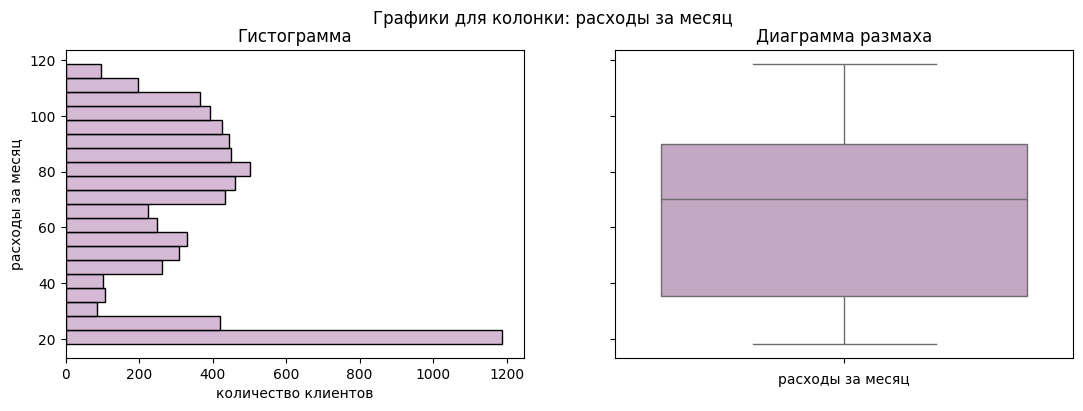

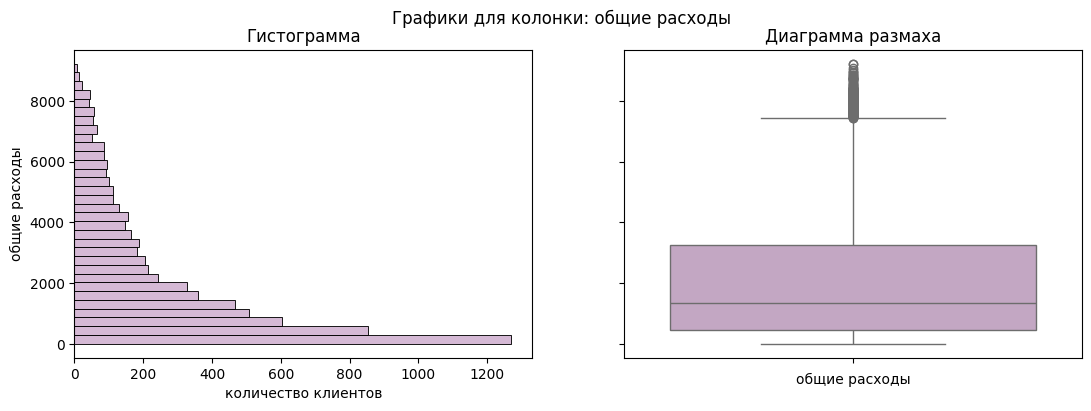

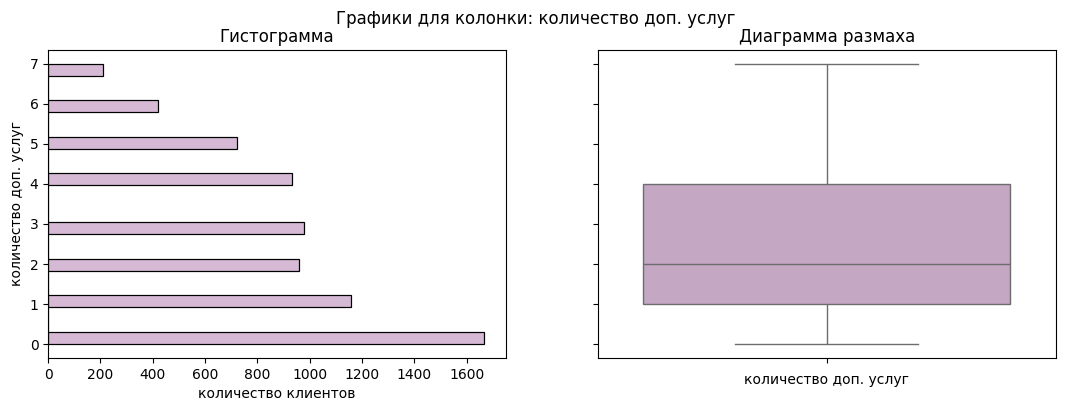

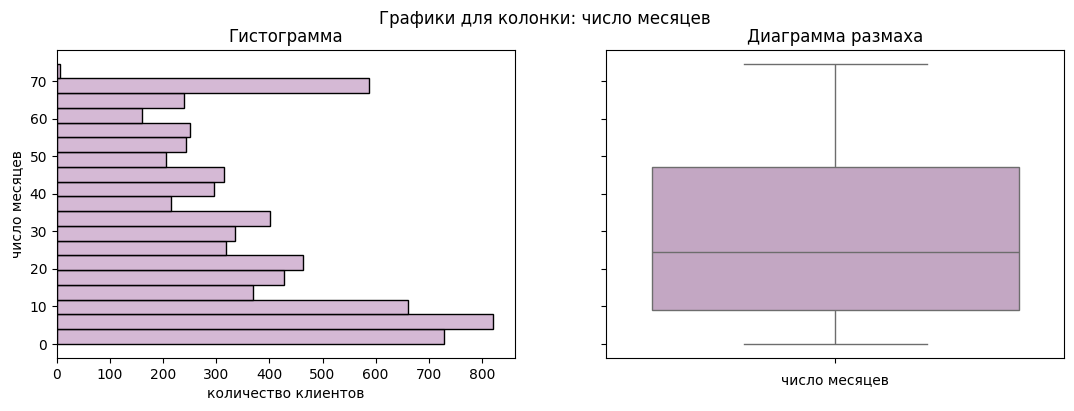

In [ ]:
# создаем список с колонками
num_col_list = ['MonthlyCharges', 'TotalCharges', 'ServicesNum', 'MonthsNum']

# применяем функцию
num_col_analysis(data_merged, num_col_list, col_dict)

По числовым признаком можно сделать следующие выводы: клиенты, которые ушли, в основном больше тратили на услуги компании из расчета как за месяц, так и за весь период пользования услугами: 84,2 против 69,2, что тратили оставшиеся клиенты за месяц, и 2139,03 против 1192,8 - за весь период.

Оставшиеся клиенты чаще не покупали никаких дополнительных услуг (в медиане покупали 2 услуги), ушедшие клиенты - 4 услуги (медиана).

Ушедших клиентов можно было бы назвать постоянными (оставались пользователями услуг компании достаточно продолжительный период - 30,06 месяцев, в отличие от оставшихся клиентов, которые в основном либо недавно ими стали (до 10 месяцев пользования услугами), либо, наоборот, пользуются услугами уже более 60 месяцев.

Также на диаграммах размаха по признаку `TotalCharges` видны выбросы. Изучим их отдельно, вероятнее всего это клиенты, которые были пользователями услуг компании на протяжении долгих лет. Выведем медиану признака `MonthsNum` для таких клиентов.

In [ ]:
# выводим медиану MonthsNum для клиентов с TotalCharges >= 6891
print('Медиана MonthsNum:', data_merged.loc[data_merged['TotalCharges'] >= 6891, 'MonthsNum'].median())

Медиана MonthsNum: 69.77


Да, все верно, это не выбросы в данных, а просто постоянные клиенты.

<a id='section3.3'></a>
### Анализ категориальных признаков

Изучим категориальные признаки в зависимости от того, ушел клиент или остался. Для построения диаграмм создадим функцию и применим ее к категориальным признакам.

In [ ]:
def cat_col_analysis(df, cat_col_list, col_dict):
    colors = sns.color_palette('pastel')
    df['sum'] = 1

    for i in cat_col_list:

        if i == 'target':
            # круговая диаграмма для target
            df_grouped = df.groupby(i)[i].count()
            labels = ['Нет', 'Да']
            plt.pie(df_grouped, labels = labels, colors = colors, autopct='%.1f%%')
            plt.title(f'Круговая диаграмма признака "{col_dict[i]}"', loc = 'center')
            plt.show()

        else:
            df['sum'] = 1
            pt = df.pivot_table(index=['target', i], values='sum', aggfunc='sum')
            pt = pt.reset_index()
            pt.loc[pt['target'] == 0, 'target'] = 'клиент не ушел'
            pt.loc[pt['target'] == 1, 'target'] = 'клиент ушел'

            barplot = sns.barplot(data=pt, x=pt['target'], y=pt['sum'], hue=pt[i])
            plt.title(f'Столбчатая диаграмма признака "{col_dict[i]}"', loc = 'center')
            barplot.legend()
            barplot.set_ylabel('количество клиентов')
            barplot.set_xlabel(f'{col_dict[i]}')
            plt.show()

    del df['sum']

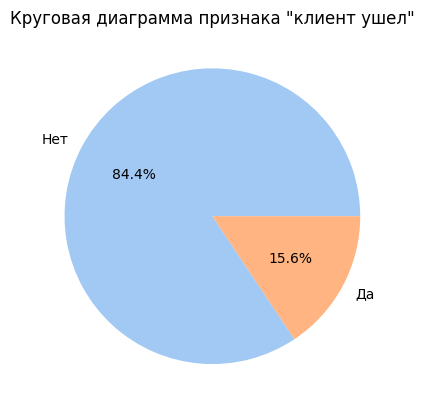

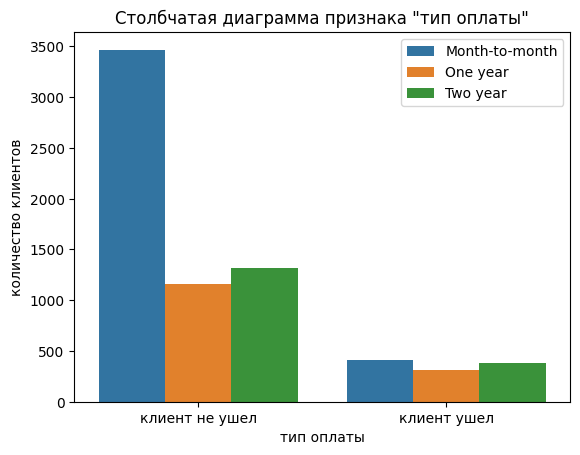

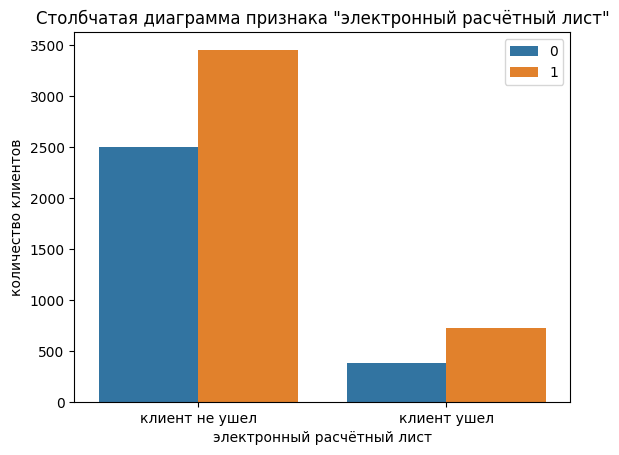

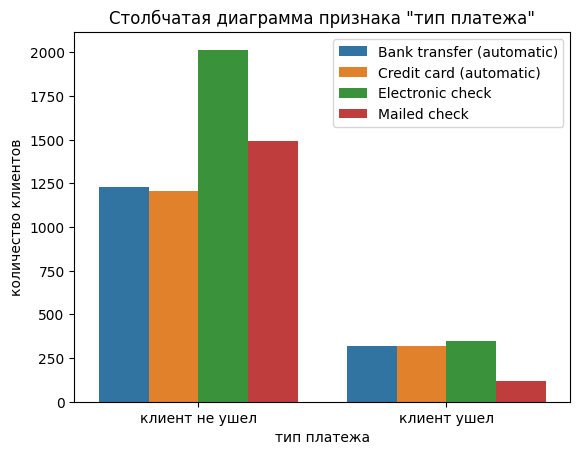

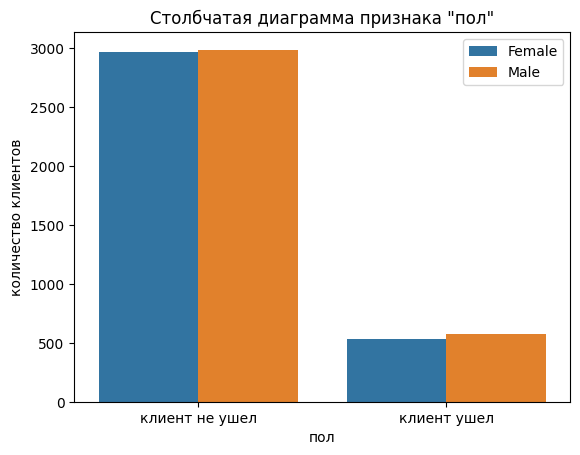

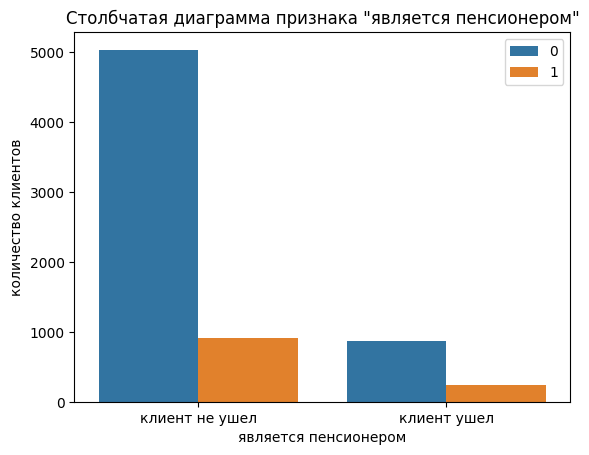

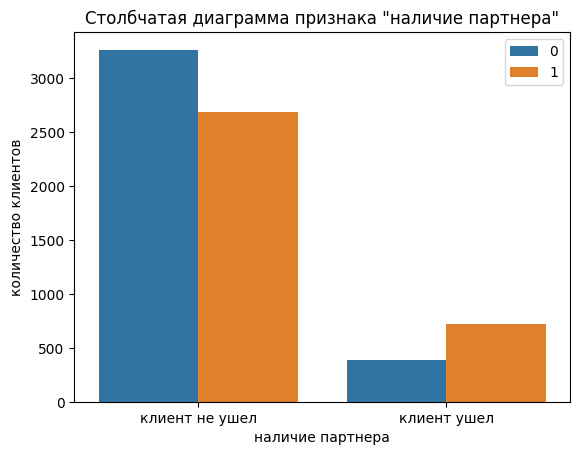

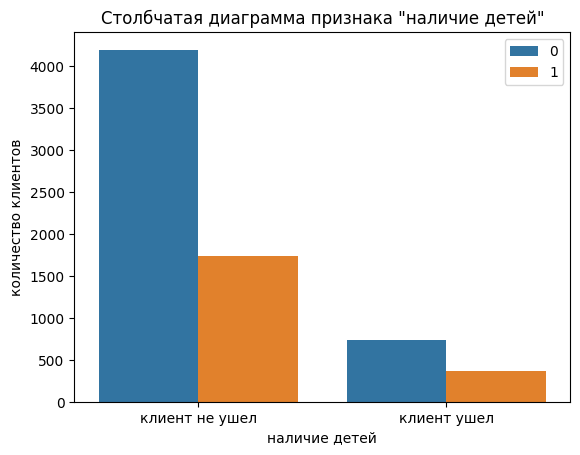

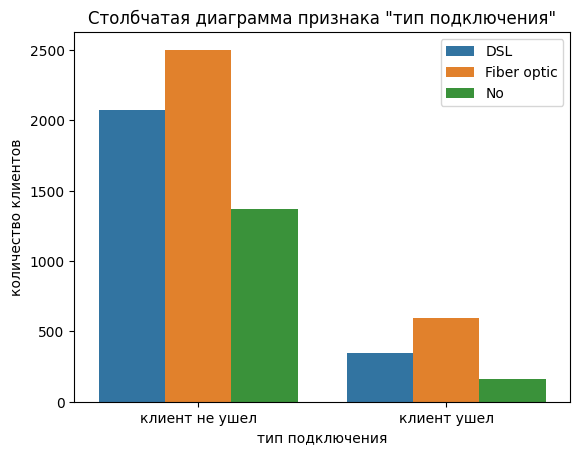

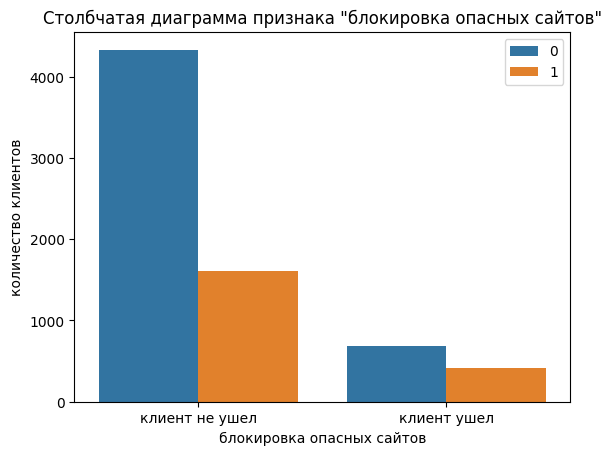

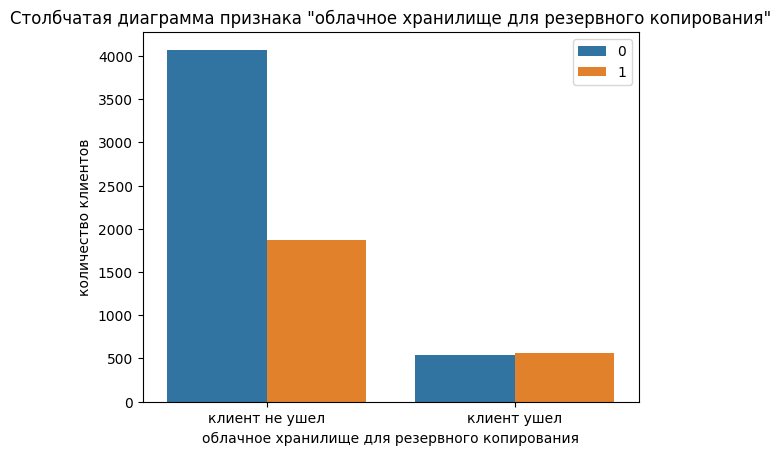

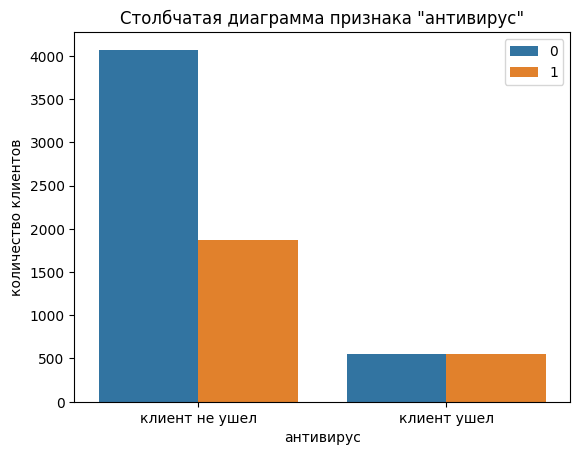

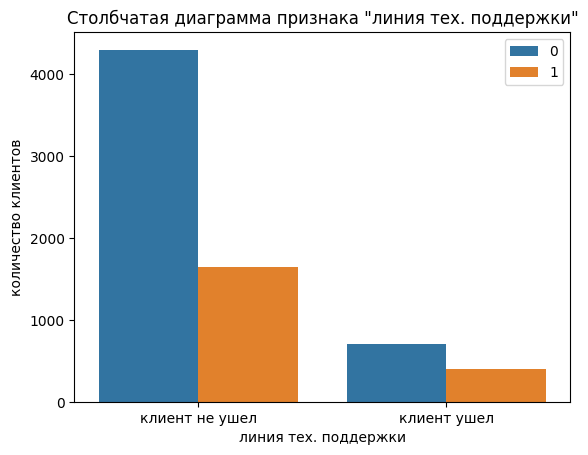

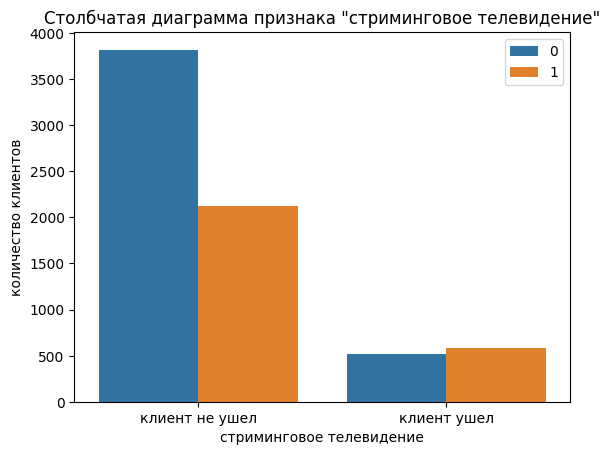

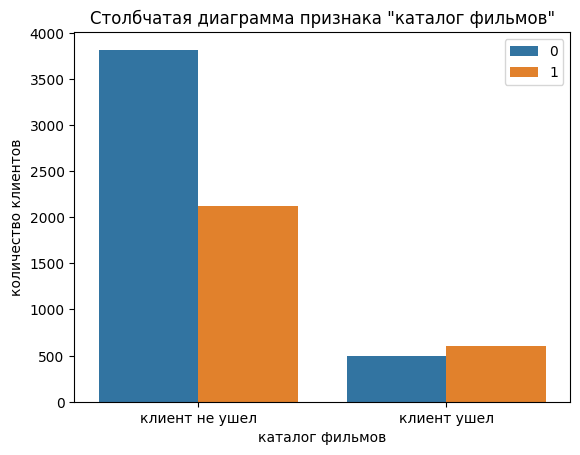

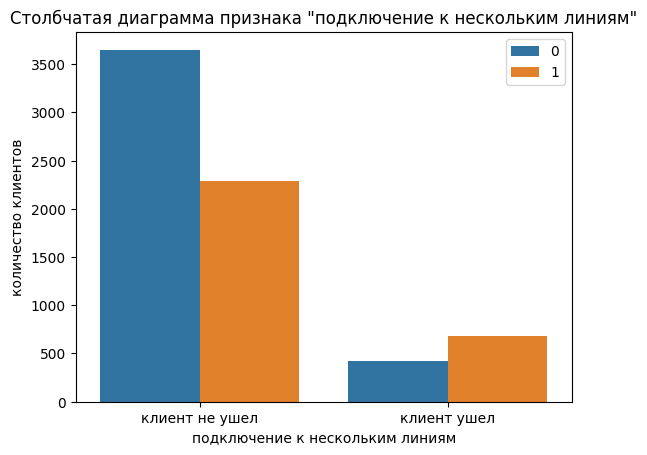

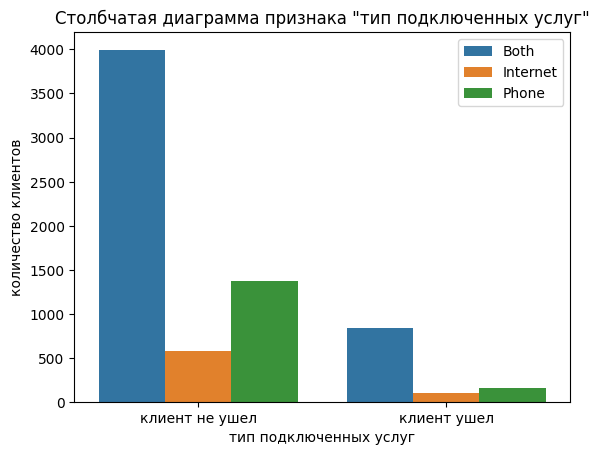

In [ ]:
# создаем список с колонками
cat_col_list = ['target', 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',\
               'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',\
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',\
               'ServiceType']

# применяем функцию
cat_col_analysis(data_merged, cat_col_list, col_dict)

Клиенты, которые ушли:
1. Пользовались всеми типами оплаты (`Type`) в равной степени (отличие от оставшихся клиентов: они выбирали в основном помесячынй тип оплаты);
2. Чаще использовали электронный расчетный лист (совпадает с оставшимися клиентами);
3. Редко использовали Mailed check в качестве типа платежа (отличие от оставшихся клиентов: они в меньшей степени использовали автоматические оплаты через банк и кредитные карты);
4. По половой принаджежности различий нет (совпадает с оставшимися клиентами);
5. В большинстве случаев не пенсионеры (совпадает с оставшимися клиентами);
6. Имели партнера (отличие от оставшихся клиентов: они чаще не имели партнера);
7. Не имели детей (совпадает с оставшимися клиентами);
8. Использовали типы подключения интернета аналогичные оставшимся клиентам (в основном Fiber optic);
9. Подключали следующие дополнительные услуги: стриминговое телевидение, каталог фильмов, подключение телефона к нескольким линиям одновременно. В равной степени как подключали, так и нет, следующие услуги: облачное хранилище, антивирус. Выделенную линию тех. поддержки и блокировку опасных сайтов чаще не подключали. Клиенты, которые остались, в большинстве случаев не подключали доп. услуг;
10. В основном подключали оба основных типов услуг (интернет + телефония, что совпадает с оставшимися клиентами).

Поскольку ушедших клиентов меньше, чем оставшихся (15,6% от общего числа), при разбивке на тренировочную и тестовую выборки, а также при обучении моделей, стоит учитывать эту особенность.

<a id='section3.4'></a>
### Корреляционный анализ

Проведем корреляционный анализ всех признаков.

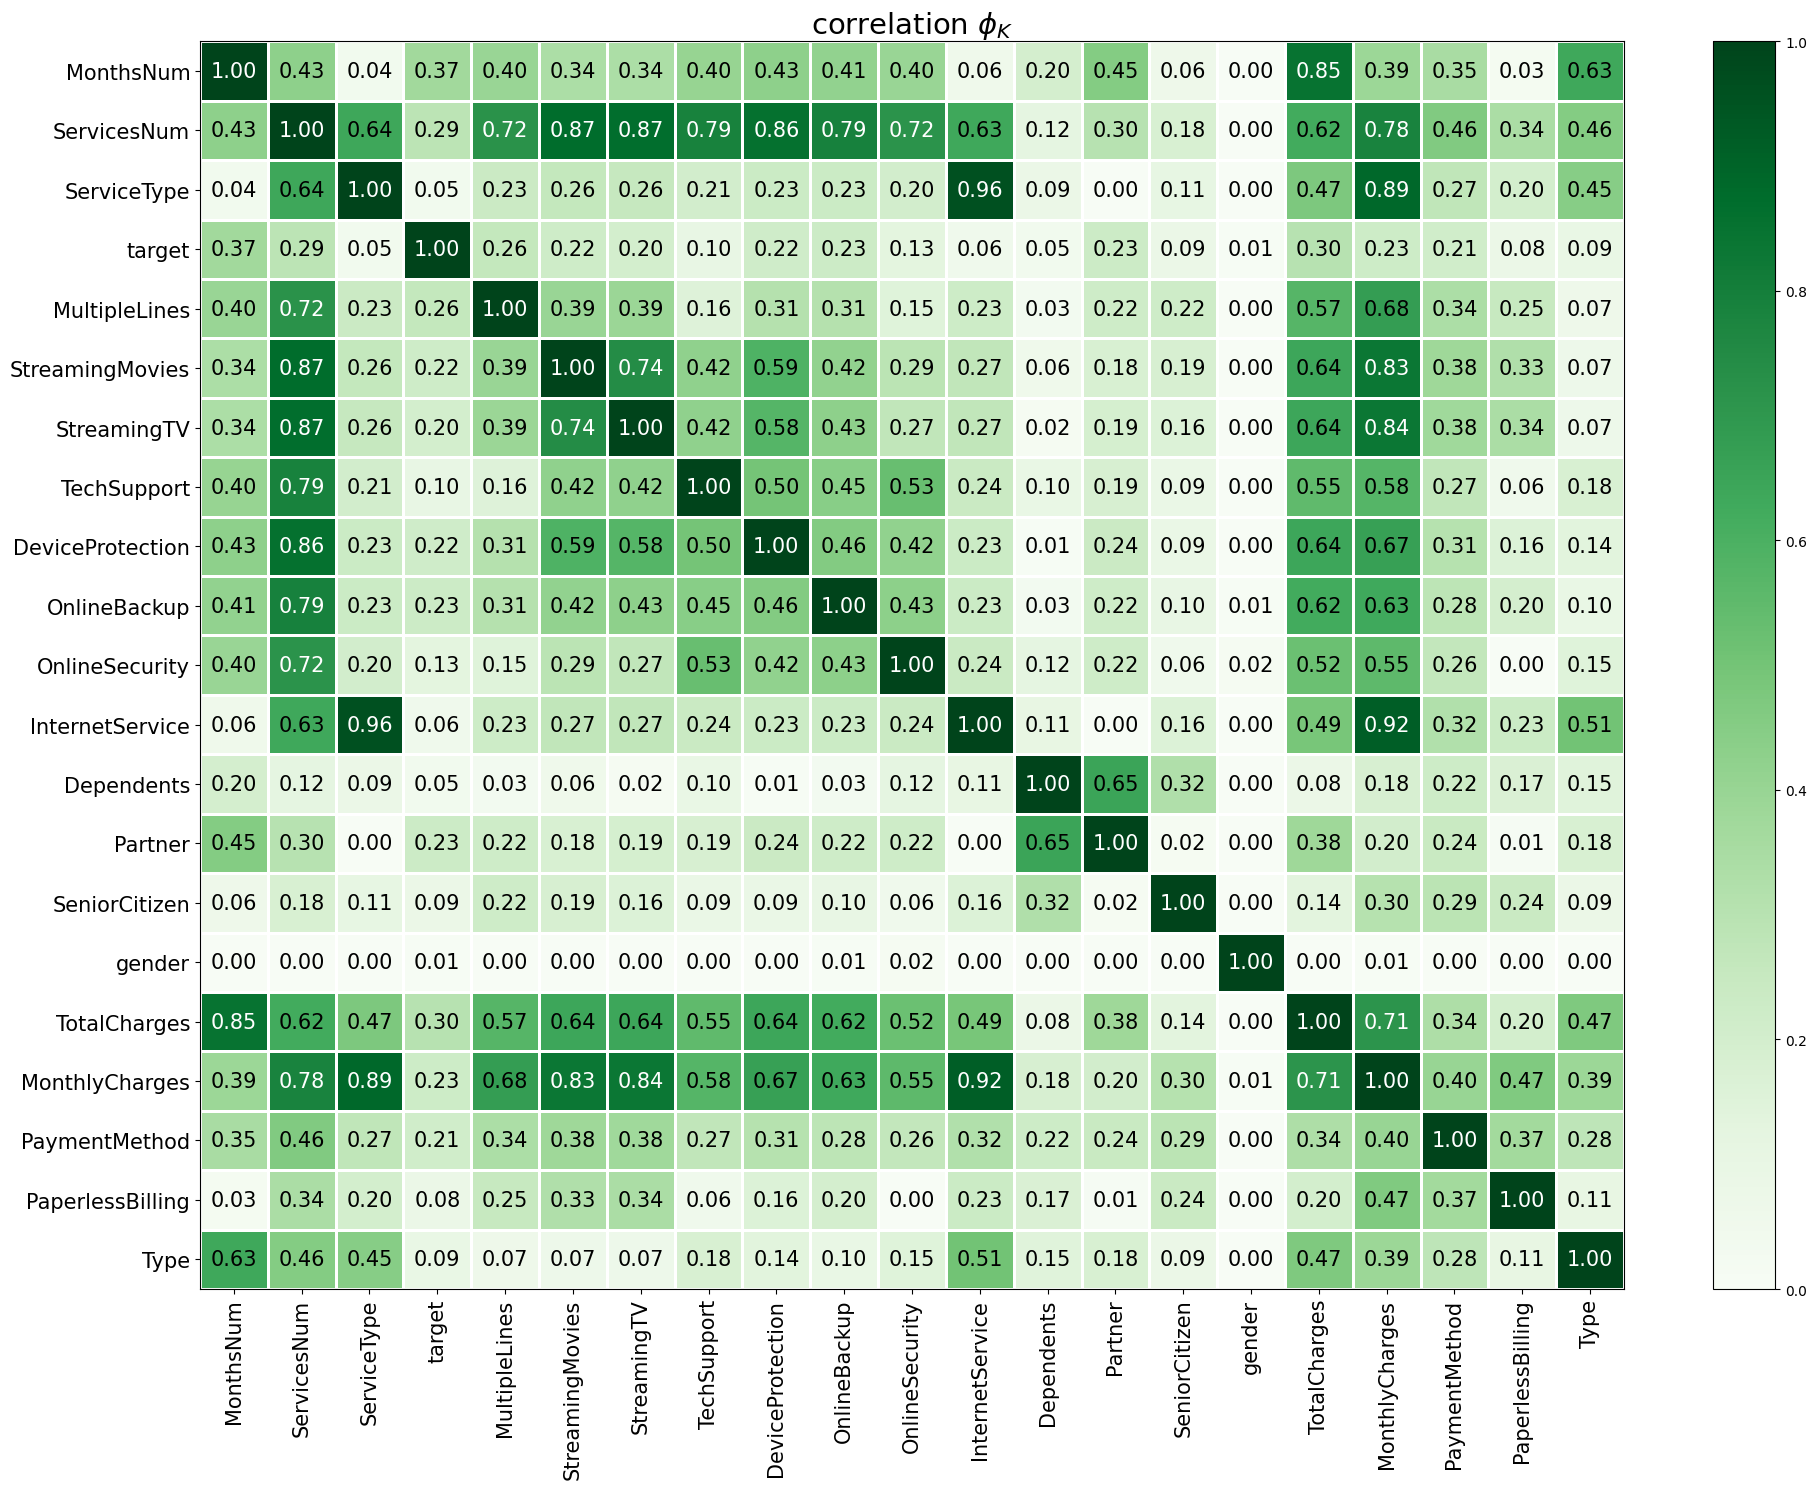

In [ ]:
# создаём список с наименованиями числовых признаков
interval_cols = num_col_list

# матрица корреляций
phik_overview = phik_matrix(data_merged, interval_cols=interval_cols)

# визуализация матрицы корреляций
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

С целевым признаком нет явной корреляции ни у одного из обучающих. Больше всего коррелируют созданные нами признаки, но даже они не показывают сильной корреляции:
* `MonthsNum` имеет коэффицент корреляции фи 0,37 (умеренная корреляция);
* `TotalCharges` - 0,30 (умеренная корреляция);
* `ServiceNum` - 0,29 (слабая корреляция).

Также есть признаки, которые сильно коррелируют с другми обучающими признаками, но слабо коррелируют с целевым:
* `MonthlyCharges`;
* `TotalCharges`;
* `InternetService`;
* `ServiceNum`.

Для обучения оставим созданный нами признак `ServiceNum` и уберем признаки, которые легли в его основу. Также по количеству месяцев, дополнительных и основных услуг можно примерно оценить месячные и общие расходы. Не будем использовать колонки `MonthlyCharges` и `TotalCharges` для обучения моделей. Также попробуем убрать `InternetService` (коррелирует с `ServiceType`) и признаки, по которым две когорты особо не отличаются друг от друга (`gender`, `SeniorCitizen` и `PaperlessBilling`).

**Вывод:**

1. Созданы дополнительные признаки:
* `target` - целевой признак (отражает факт ухода клиента);
* `ServiceType` - основные типы услуг, которыми пользуется клиент (интернет, телефония или оба);
* `ServicesNum` - количество дополнительных приобретенных услуг;
* `MonthsNum` - число месяцев пользования услугами компании.

2. Изучены числовые признаки датафрейма: основные выводы из этого раздела - ушедшие клиенты, в отличие от оставшихся, более длительное время пользовались услугами компании и приобретали дополнительные услуги (обычно 4 шт.), и тратили бОльшие суммы, соответственно.

3. Проведен анализ категориальных признаков: отличия от ушедших клиентов в видны по следующим признакам:
* ушедшие клиенты пользовались всеми типами оплаты (Type) в равной степени (оставшиеся выбирали в основном помесячынй тип оплаты);
* редко использовали Mailed check в качестве типа платежа (оставшиеся в меньшей степени использовали автоматические оплаты через банк и кредитные карты);
* имели партнера (оставшиеся чаще не имели партнера);
* подключали следующие дополнительные услуги: стриминговое телевидение, каталог фильмов, подключение телефона к нескольким линиям одновременно. В равной степени как подключали, так и нет, следующие услуги: облачное хранилище, антивирус. Выделенную линию тех. поддержки и блокировку опасных сайтов чаще не подключали. Клиенты, которые остались, в большинстве случаев не подключали доп. услуг;

4. При корреляционном анализе выявлены признаки, которые сильно коррелируют между собой, и те, по которым особо не было отличий между двумя изучаемыми когортами клиентов, было принято решение не использовать их при обучении моделей. Дополнительно созданные признаки показали бОльшую корреляцию с целевым. Признаки, которые легли в их основу, исключаются из обучения.

<a id='section4'></a>
## Подготовка данных

Создадим пайплайны с предобработкой входных признаков. Но для начала отделим целевой признак от входящих и выделим тестовую выборку в размере 0,25 от исходной (на ней будем тестировать только лучшую отобранную модель) и удалим лишние колонки.

In [ ]:
# входящие признаки
X = data_merged.drop(['target', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',\
                       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'MonthlyCharges', 'InternetService',\
                       'TotalCharges', 'gender', 'SeniorCitizen', 'PaperlessBilling'], axis=1)


# целевая переменная
y = data_merged['target']

# разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y)

# проверка разбивки
print('Размерность входных признаков тренировочной выборки', X_train.shape)
print('Размерность входных признаков обучающей выборки', X_test.shape)
print('Размерность целевого признака тренировочной выборки', y_train.shape)
print('Размерность целевого признака обучающей выборки', y_test.shape)

Размерность входных признаков тренировочной выборки (5282, 7)
Размерность входных признаков обучающей выборки (1761, 7)
Размерность целевого признака тренировочной выборки (5282,)
Размерность целевого признака обучающей выборки (1761,)


Данные разбились корректно.

Создадим пайплайны с предобработкой данных и подбором гиперпараметров для моделей.

In [ ]:
# создаем списки с названиями признаков
ohe_columns = X_train.select_dtypes(include='object').columns.tolist()

num_col_list_cc = num_col_list.copy()
num_col_list_cc.remove('TotalCharges')
num_col_list_cc.remove('MonthlyCharges')
num_columns = num_col_list_cc

In [ ]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Объединяем в один пайплайн и добавляем масштабирование числовых переменных. Неуказанные колонки будут передаваться модели в неизмененном виде (признаки, значения которых 0 и 1).

In [ ]:
# объединяем предобработку всех видов признаков
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
    ],
    remainder='passthrough'
)

Подбирать гиперпараметры будем отдельно для каждой модели с помощью RandomizedSearchCV. Создадим общие пайплайны для каждой рассматриваемой модели.

In [ ]:
# итоговый пайплайн с DecisionTreeClassifier
pipe_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)

# итоговый пайплайн с LogisticRegression
pipe_logreg = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)

Для CatBoostClassifier предобработка данных не нужна, инициализируем модель отдельно и обозначим категориальные признаки в отдельной переменной.

In [ ]:
# инициализируем модель CatBoostClassifier
catboost = CatBoostClassifier(random_seed=RANDOM_STATE, auto_class_weights='Balanced')

# выделяем категориальные признаки для CatBoostClassifier
cat_features = ['Type', 'PaymentMethod', 'Partner', 'Dependents', 'ServiceType']

Создаем словарь с гиперпараметрами для моделей.

In [ ]:
# словарь с параметрами для модели DecisionTreeRegressor()
param_tree = [

    {
        'models__max_depth': range(3,20),
        'models__max_features': range(3,20),
        'models__min_samples_split': range(3,8)
    }

]

# словарь для модели LogisticRegression
param_logreg = {
  'models__C': range(1,15)
}

# словарь для модели CatBoostClassifier
param_catboost = {
    'depth': range(5,10),
    'iterations': [100, 150, 200],
    'min_data_in_leaf': range(5,20)
}

<a id='section5'></a>
## Обучение моделей

Для подбора гиперпараметров будем испльзовать кросс-валидацию через RandomizedSearchCV с 5-ю фолдами. В качестве метрики рассмотрим ROC-AUC, поскольку она наиболее точно отражает запрос бизнеса: поддерживание баланса между недополучением прибыли от клиентов, которые не собирались уходить, но мы предложили им, допустим, скидку на услуги, и полную потерю всех клиентов, которые собирались уходить, и мы не предложили им более выгодные условия.

Поочереди подберем гиперпараметры для каждой модели и выберем среди них лучшую.

In [ ]:
# подбираем гиперпараметры с помощью RandomizedSearchCV
rs_tree = RandomizedSearchCV(
    pipe_tree,
    param_tree,
    cv=5,
    scoring='roc_auc',
    n_iter=15,
    random_state=RANDOM_STATE,
    n_jobs=-1)
rs_tree.fit(X_train, y_train)

# выводим результат на экран
print('\nМетрика для лучшей модели на кросс-валидации:\n', rs_tree.best_score_)
print('\nПараметры лучшей модели:\n', rs_tree.best_params_)


Метрика для лучшей модели на кросс-валидации:
 0.7956026692853276

Параметры лучшей модели:
 {'models__min_samples_split': 5, 'models__max_features': 16, 'models__max_depth': 7}


In [ ]:
# подбираем гиперпараметры с помощью RandomizedSearchCV
rs_catboost = RandomizedSearchCV(
    catboost,
    param_catboost,
    cv=5,
    scoring='roc_auc',
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1)
rs_catboost.fit(X_train, y_train, cat_features=cat_features)

# выводим результат на экран
print('\nМетрика для лучшей модели на кросс-валидации:\n', rs_catboost.best_score_)
print('\nПараметры лучшей модели:\n', rs_catboost.best_params_)

Learning rate set to 0.091733
0:	learn: 0.6629871	total: 57.7ms	remaining: 11.5s
1:	learn: 0.6404754	total: 69.3ms	remaining: 6.86s
2:	learn: 0.6211255	total: 79.4ms	remaining: 5.21s
3:	learn: 0.6046725	total: 88ms	remaining: 4.31s
4:	learn: 0.5876275	total: 97.3ms	remaining: 3.79s
5:	learn: 0.5756698	total: 107ms	remaining: 3.45s
6:	learn: 0.5655393	total: 118ms	remaining: 3.26s
7:	learn: 0.5581265	total: 126ms	remaining: 3.04s
8:	learn: 0.5504490	total: 135ms	remaining: 2.86s
9:	learn: 0.5449288	total: 144ms	remaining: 2.73s
10:	learn: 0.5372862	total: 152ms	remaining: 2.62s
11:	learn: 0.5334997	total: 160ms	remaining: 2.5s
12:	learn: 0.5292958	total: 167ms	remaining: 2.41s
13:	learn: 0.5251030	total: 175ms	remaining: 2.32s
14:	learn: 0.5211864	total: 182ms	remaining: 2.25s
15:	learn: 0.5193739	total: 190ms	remaining: 2.19s
16:	learn: 0.5166494	total: 202ms	remaining: 2.18s
17:	learn: 0.5129030	total: 210ms	remaining: 2.12s
18:	learn: 0.5107286	total: 218ms	remaining: 2.07s
19:	learn

In [ ]:
# подбираем гиперпараметры с помощью RandomizedSearchCV
rs_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_logreg,
    cv=5,
    scoring='roc_auc',
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1)
rs_logreg.fit(X_train, y_train)

# выводим результат на экран
print('\nМетрика для лучшей модели на кросс-валидации:\n', rs_logreg.best_score_)
print('\nПараметры лучшей модели:\n', rs_logreg.best_params_)


Метрика для лучшей модели на кросс-валидации:
 0.7396289380344803

Параметры лучшей модели:
 {'models__C': 2}


**Вывод:** лучшая модель - CatBoostClassifier(random_seed=RANDOM_STATE, auto_class_weights='Balanced', min_data_in_leaf=7, iterations=200, depth=6). На обучающей выборке метрика ROC-AUC равна 0.8788. С помощью данной модели предскажем уход клиентов из тестовой выборки.

<a id='section6'></a>
## Предсказание на тестовой выборке

In [ ]:
# инициализируем лучшую модель
model = rs_catboost.best_estimator_
model.fit(X_train, y_train, cat_features=cat_features)

# предсказываем на тестовых данных
y_test_pred = model.predict(X_test)
preds = model.predict_proba(X_test)

# выводим результат на экран
print('Метрика на тестовой выборке:', roc_auc_score(y_test, preds[:,1]))

Learning rate set to 0.091733
0:	learn: 0.6629871	total: 25.4ms	remaining: 5.06s
1:	learn: 0.6404754	total: 55.8ms	remaining: 5.53s
2:	learn: 0.6211255	total: 67.6ms	remaining: 4.44s
3:	learn: 0.6046725	total: 79.2ms	remaining: 3.88s
4:	learn: 0.5876275	total: 90.3ms	remaining: 3.52s
5:	learn: 0.5756698	total: 100ms	remaining: 3.24s
6:	learn: 0.5655393	total: 109ms	remaining: 3.01s
7:	learn: 0.5581265	total: 118ms	remaining: 2.83s
8:	learn: 0.5504490	total: 129ms	remaining: 2.73s
9:	learn: 0.5449288	total: 139ms	remaining: 2.65s
10:	learn: 0.5372862	total: 160ms	remaining: 2.75s
11:	learn: 0.5334997	total: 169ms	remaining: 2.65s
12:	learn: 0.5292958	total: 184ms	remaining: 2.64s
13:	learn: 0.5251030	total: 195ms	remaining: 2.59s
14:	learn: 0.5211864	total: 210ms	remaining: 2.59s
15:	learn: 0.5193739	total: 231ms	remaining: 2.65s
16:	learn: 0.5166494	total: 256ms	remaining: 2.76s
17:	learn: 0.5129030	total: 281ms	remaining: 2.84s
18:	learn: 0.5107286	total: 310ms	remaining: 2.96s
19:	le

Метрика на тестовой выборке 0.8869, что удовлетворяет ТЗ. Переобучения не произошло, поскольку на тренировочной выборке метрика даже немного ниже.

Построим график кривой ROC-AUC.

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, preds[:,1])

# строим график кривой ROC-AUC
fig = px.line(x=fpr, y=tpr, title='ROC-AUC кривая', width=800, height=600)
fig.update_layout(yaxis_title='True Positive Rate (TPR)', xaxis_title='False Positive Rate (FPR)')
fig.show()

Чтобы выяснить, какие признаки наиболее значимы для модели, построим столбчатую диаграмму из библиотеки Shap.

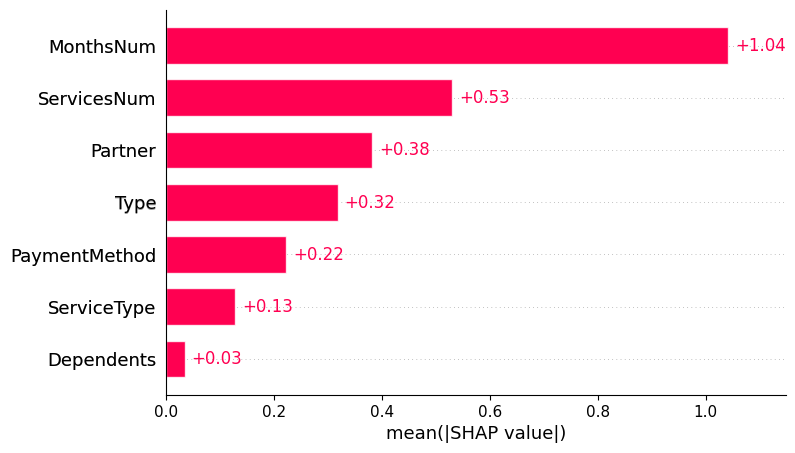

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train, y_train)

# строим столбчатую диаграмму Shap
shap.plots.bar(shap_values)

По значимости для модели признаки расположились в следующем порядке:
1. `MonthsNum`;
2. `ServicesNum`;
3. `Partner`;
4. `Type`;
5. `PaymentMethod`;
6. `ServiceType`;
7. `Dependents`.

**Вывод:** выбранная нами модель показала результат ROC-AUC на тестовой выборке 0.8867, что удовлетворяет условиям ТЗ. Наиболее значимыми для модели являются признаки `MonthsNum` и `ServicesNum`.

<a id='section7'></a>
## Выводы и рекомендации Заказчику

В ходе работы был проведен первичный анализ данных и их предобработка: заменены пропуски (пробелы) в `TotalCharges` на 0, значения в категориальных признаках Yes/No изменены на 1/0. Все датафреймы объединены в один, технически образовавшиеся пропуски заполнены значением 0 (No).

На основе уже имеющихся признаков синтезированы дополнительные (`MonthsNum`, `ServicesNum`, `ServiceType`), в том числе и целевой (`target`).

Проведен исследовательский и корреляционный анализы данных, в ходе которых отобраны признаки для обучения моделей: `MonthsNum`, `ServicesNum`, `Partner`, `Type`, `PaymentMethod`, `ServiceType`, `Dependents`.

С помощью RandomizedSearchCV обучены следующие модели и подобраны гиперпараметры к ним: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier.

Из всех моделей лучше всего себя показала CatBoostClassifier со следующими гиперпараметрами: random_seed=RANDOM_STATE, auto_class_weights='Balanced', min_data_in_leaf=7, iterations=200, depth=6. На обучающей выборке метрика ROC-AUC равна 0.8785. Данная модель была использована для предсказания оттока клиентов на тестовой выборке: результат ROC-AUC - 0.8867.

По значимости для модели признаки расположились в следующем порядке:
1. `MonthsNum`;
2. `ServicesNum`;
3. `Partner`;
4. `Type`;
5. `ServiceType`;
6. `Partner`;
7. `Dependents`.

Поскольку при исследовательском анализе данных было выявлено, что уходящие клиенты, как правило, подключали бОльшее количество дополнительных услуг и их расходы на них выше, чем у тех клиентов, которые остались, можно предположить, что пользователей, возможно, не устраивает соотношение цена-качество доп. услуг, поэтому предложение таким клиентам специальных условий или промокодов, вероятно, снизит отток клиентов. А разработанная нами модель предскажет, какие клиенты собираются уходить.